###  Tarea 5

## Modelación de drenaje contaminante no estacionario

#### MOOC: Transferencia de Calor y Masa Computacional

Problema: Modelado del Drenaje de un Contaminante Orgánico en Aguas Subterráneas Tras un Derrame

Imagine que usted trabaja en el Laboratorio Nacional de Investigación Ambiental en un proyecto que busca evaluar el impacto de contaminantes orgánicos en el suministro de aguas subterráneas. Usted es responsable de desarrollar un modelo que simule el drenaje de un contaminante orgánico después de un derrame accidentado.

La Figura 1 ilustra un acuífero subterráneo representado por un rectangulo de $L_w$ m de altura y W x $S_w$ de base, donde se ha producido un derrame de un solvente orgánico volátil que se ha filtrado en el suelo.

<div> <img src="drenaje.png" width="600"/> <figcaption>Figura 1: Modelo de acuífero afectado por derrame de solvente orgánico</figcaption> </div>

A medida que el contaminante se mueve hacia el acuífero, la concentración del contaminante no debe exceder los niveles seguros de 2 mg/L, ya que niveles más altos pueden resultar en la contaminación del suministro de agua potable.

La ecuación de conservación de masa para el contaminante dentro del acuífero se describe como:

$$R*\frac{\partial C}{\partial t}= D_h \frac{\partial^2 C}{\partial x^2}-v \frac{\partial C}{\partial x}-\lambda C$$

Donde:


$C$ es la concentración del contaminante,
$x$ es la coordenada espacial en la que se difunde el contaminante,
$D_h$ es el coeficiente de difusión-dispersión hidrodinámico,
$v$ es la velocidad de infiltración,
$\lambda$ es el coeficiente de degracación,
$R$ es el factor de retardo para la absorción lineal

Las condiciones de contorno se definen como:

CB1:
La concentración en x=0 a traves del tiempo varía según la siguiente expresión
$$ C(x=0,t)= C_0 \cdot \exp (-\beta t)$$

CB2:
El flux molar en x=L es igual a 0
$$ \frac{\partial}{\partial x} C(x=L,t)= 0$$


 
Se le solicita evaluar si las condiciones actuales de contención y remediación son suficientes para prevenir que la concentración del contaminante en cualquier punto del acuífero exceda los niveles seguros establecidos. ¿Qué estrategias de mitigación podrían implementarse si se determinara que las concentraciones superan el límite permitido?

#### Parte 1. Discretice la EDP utilizando diferencias finitas de segundo orden y el método FTCS

#### 1.1 Discretice los nodos interiores, utilizando:
* Diferencias finitas hacia adelante de primer orden en el tiempo para la derivada temporal
* Diferencias finitas centrales de segundo orden en el espacio para el término de difusión/dispersión y diferencias finitas hacia atrás de primer orden para el término convectivo.

#### 1.2 Encuentre los coeficientes de la matriz A en la ecuación de evolución

#### 1.3) Discretice las condiciones de borde
* Utilice diferencias finitas hacia adelante o atrás, según corresponda, de segundo orden.
* Se le recomienda despejar las temperaturas del nodo inicial $T^{t+1}_0$ y el nodo final $T_N^{t}$ en función de los nodos adyacentes.
* Esto le permitirá implementar el método de manera más sencilla.
* En esta implementación, usted deberá dejar la primera y última fila de la matriz de coeficientes A vacía, así como también el primer y último elemento del vector $\mathbf{b}$ vacío.

### Parte 2) Implementación del método numérico

#### 2.1 - Importar módulos

In [1]:
# Cálculos numéricos
import numpy as np

# Gráficos
import matplotlib.pyplot as plt

# Mapas de colores
from matplotlib import cm

# 2.2 Declaración de parámetros físicos

In [2]:
#Parámetros
R=1.5
D_h=0.38
v=0.33
lamb=0.15
beta=0.0768
c_0=1
X=25

#### 2.3 Definición de los parámetros de grilla y computacionales

Se le solicita resolver el problema considerando los siguientes parámetros:

* 200 nodos en la dirección radial


In [3]:
# Número de nodos
n_x= 200

# Crear un dominio discretizado
x=np.linspace(0,X,n_x+1)

# Espaciamiento o paso radial
dx=X/(n_x) #m

# Paso de tiempo
dt= 0.01 #year

# Construcción de matriz A y vector del lado derecho
A=np.zeros([n_x+1, n_x+1])


#### Número de Fourier y Courant

In [4]:
Fo=D_h*dt/(R*dx**2)
Cour=v*dt/dx
print(Fo,Cour)

0.16213333333333332 0.026400000000000003


Número de Fourier es menor a 0.5 y Courant es menor a 1, por lo que cumplen la condición de estabilidad

#### 2.4 Rellenar matriz A - nodos interiores

In [5]:
# Iteración en nodos interiores
for i in range(1,n_x):
    
    # Coeficiente que acompaña a C_{i-1}^j
    A[i,i-1]=(D_h/dx**2 + v/(dx))/R
  
    # Coeficiente que acompaña a C_{i}^j
    A[i,i]=(-2*D_h/dx**2 -lamb - v/(dx))/R

    # Coeficiente que acompaña a C_{i+1}^j
    A[i,i+1]=(D_h/dx**2)/R


In [6]:
print(A[2,1],A[2,2],A[2,3])

17.973333333333333 -34.28666666666667 16.213333333333335


In [7]:
# Vector del lado derecho
b=np.ones(len(A))*0

In [8]:
# Condiciones de borde

#Concentración en x=0 varía con el tiempo
A[0,0]=0
b[0]=0

A[-1,-1]=3
A[-1,-2]=-4
A[-1,-3]=1
b[-1]=0


#### 2.5 - Definir parámetros FTCS

In [9]:
# Tiempo inicial
t_0=0

# Tiempo final
t_f = 30

# Grabe los resultados después de una fracción que estime conveniente. Por ejemplo, t = 3 s:
write_interval= 6

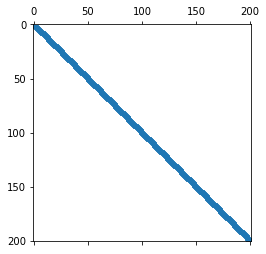

In [10]:
fig, ax =plt.subplots(1,1, figsize=[4,4])
ax.spy(A, markersize=3)
plt.show()

#### 2.6 Implementar el algoritmo FTCS

In [11]:
## Algoritmo FTCS

# Lista en que se acumulan los tiempos donde se graban los perfiles de concentración
t_vec=[]

# Lista en que se acumulan los perfiles de concentración para cada write_interval
C_num=[]

# Inicializar vector que contiene la concentración inicial 
C_inicial=np.ones(len(A))*0


# Copie la temperatura T en otra variable, utilizando la función np.copy()
C_old=np.copy(C_inicial)


#Inicialización de tiempo inicial y final
t=t_0
t_max=t_f

# Iteración de evolución
while t<t_max:
    
    # Actualizar nodos interiores
    C_new=C_old+(np.dot(A,C_old)+b)*dt
        
    # Actualizar tiempo
    t+=dt
        
    # Actualizar condiciones de borde
    C_new[0]=c_0*np.exp(-beta*t)
    C_new[-1]=(4*C_new[-2]-C_new[-3])/3
    
        
        
    # Crear una copia de la nueva temperatura
    C_old=np.copy(C_new)


    # Definir un control de flujo para guardar el perfil de temperatura
    # cada vez que se cumpla un intervalo de tiempo previamente definido
    if (t%write_interval)<1.1*dt and t-dt>0:
        # Guardamos el perfil de temperatura
        C_num.append(C_new)
        
        # Guardamos el tiempo
        t_vec.append(t)
    


# Graficar

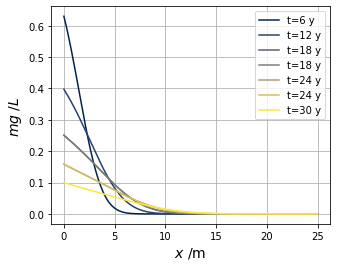

In [12]:
fig, ax=plt.subplots(1,1,figsize=[5,4])
n_con=len(C_num)
cividis=cm.get_cmap("cividis",n_con)
colour=[cividis(i/n_con) for i in range(n_con)]

for i in range(len(C_num)):
    plt.plot(x,C_num[i],color=colour[i],label="t=%.0f y" % t_vec[i])

plt.xlabel("$x$ /m ", size=14)
plt.ylabel("$mg $ $/L $ ", size=14)
plt.grid()
plt.legend()
# plt.xlim(0,1)
plt.show()

In [13]:
suma=0
cont=0
for i in C_num[-1]:
    suma=suma+i
    cont=cont+1
promedio=suma/cont
print(promedio)

0.023419985647042965


La concentración promedio es de 0.0234 mg/L.

### Preguntas 

#### P3) Calcule la concentración promedio en el dominio despues de 30 años

In [14]:
# Sobre todo x
suma=0
len(C_num)
for i in range(len(C_num[-1])):
    suma=suma+C_num[-1][i]

prom=suma/len(C_num[-1])
print(prom)

0.023419985647042965


La concentración promedio a los 30 años es de 0.02341 mg/L

#### P5) Considere que $\lambda$ es igual a 0.

In [15]:
lamb2=0
# Iteración en nodos interiores
for i in range(1,n_x):
    
    # Coeficiente que acompaña a C_{i-1}^j
    A[i,i-1]=(D_h/dx**2 + v/(dx))/R
  
    # Coeficiente que acompaña a C_{i}^j
    A[i,i]=(-2*D_h/dx**2 -lamb2 - v/(dx))/R

    # Coeficiente que acompaña a C_{i+1}^j
    A[i,i+1]=(D_h/dx**2)/R


    
# Vector del lado derecho
b=np.ones(len(A))*0



# Condiciones de borde

#Concentración en x=0 varía con el tiempo
A[0,0]=0
b[0]=0

A[-1,-1]=3
A[-1,-2]=-4
A[-1,-3]=1
b[-1]=0



# Tiempo inicial
t_0=0

# Tiempo final
t_f = 20

# Grabe los resultados después de una fracción que estime conveniente. Por ejemplo, t = 3 s:
write_interval= 5

In [16]:
## Algoritmo FTCS

# Lista en que se acumulan los tiempos donde se graban los perfiles de concentración
t_vec=[]

# Lista en que se acumulan los perfiles de concentración para cada write_interval
C_num=[]

# Inicializar vector que contiene la concentración inicial 
C_inicial=np.ones(len(A))*0


# Copie la temperatura T en otra variable, utilizando la función np.copy()
C_old=np.copy(C_inicial)


#Inicialización de tiempo inicial y final
t=t_0
t_max=t_f

# Iteración de evolución
while t<t_max:
    
    # Actualizar nodos interiores
    C_new=C_old+(np.dot(A,C_old)+b)*dt
        
    # Actualizar tiempo
    t+=dt
        
    # Actualizar condiciones de borde
    C_new[0]=c_0*np.exp(-beta*t)
    C_new[-1]=(4*C_new[-2]-C_new[-3])/3
    
        
        
    # Crear una copia de la nueva temperatura
    C_old=np.copy(C_new)


    # Definir un control de flujo para guardar el perfil de temperatura
    # cada vez que se cumpla un intervalo de tiempo previamente definido
    if (t%write_interval)<1.1*dt and t-dt>0:
        # Guardamos el perfil de temperatura
        C_num.append(C_new)
        
        # Guardamos el tiempo
        t_vec.append(t)
    


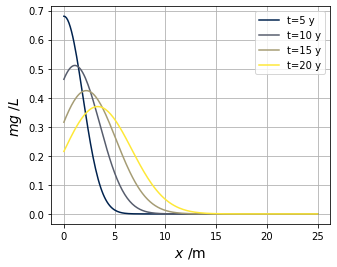

In [17]:
fig, ax=plt.subplots(1,1,figsize=[5,4])
n_con=len(C_num)
cividis=cm.get_cmap("cividis",n_con)
colour=[cividis(i/n_con) for i in range(n_con)]

for i in range(len(C_num)):
    plt.plot(x,C_num[i],color=colour[i],label="t=%.0f y" % t_vec[i])

plt.xlabel("$x$ /m ", size=14)
plt.ylabel("$mg $ $/L $ ", size=14)
plt.grid()
plt.legend()
# plt.xlim(0,1)
plt.show()

In [18]:
indice_maximo = np.argmax(C_num[-1])
print(indice_maximo)

print(C_num[-1][indice_maximo])

print(dx*indice_maximo)

27
0.3695920227763281
3.375


#### P6) Encuentre flux de contaminante organico a los 20 años en el acuifero (x=9)

In [19]:
#Parámetros
R=1.5
D_h=0.38
v=0.33
lamb=0.15
beta=0.0768
c_0=1
X=25

# Número de nodos
n_x= 200

# Crear un dominio discretizado
x=np.linspace(0,X,n_x+1)

# Espaciamiento o paso radial
dx=X/(n_x) #m

# Paso de tiempo
dt= 0.01 #year


# Construcción de matriz A y vector del lado derecho
A=np.zeros([n_x+1, n_x+1])

# Iteración en nodos interiores
for i in range(1,n_x):
    
    # Coeficiente que acompaña a C_{i-1}^j
    A[i,i-1]=(D_h/dx**2 + v/(dx))/R
  
    # Coeficiente que acompaña a C_{i}^j
    A[i,i]=(-2*D_h/dx**2 -lamb - v/(dx))/R

    # Coeficiente que acompaña a C_{i+1}^j
    A[i,i+1]=(D_h/dx**2)/R
    
# Vector del lado derecho
b=np.ones(len(A))*0

# Condiciones de borde

#Concentración en x=0 varía con el tiempo
A[0,0]=0
b[0]=0

A[-1,-1]=3
A[-1,-2]=-4
A[-1,-3]=1
b[-1]=0


In [20]:
# Tiempo inicial
t_0=0

# Tiempo final
t_f = 20

# Grabe los resultados después de una fracción que estime conveniente. Por ejemplo, t = 3 s:
write_interval= 5

In [21]:
## Algoritmo FTCS

# Lista en que se acumulan los tiempos donde se graban los perfiles de concentración
t_vec=[]

# Lista en que se acumulan los perfiles de concentración para cada write_interval
C_num=[]

# Inicializar vector que contiene la concentración inicial 
C_inicial=np.ones(len(A))*0


# Copie la temperatura T en otra variable, utilizando la función np.copy()
C_old=np.copy(C_inicial)


#Inicialización de tiempo inicial y final
t=t_0
t_max=t_f

# Iteración de evolución
while t<t_max:
    
    # Actualizar nodos interiores
    C_new=C_old+(np.dot(A,C_old)+b)*dt
        
    # Actualizar tiempo
    t+=dt
        
    # Actualizar condiciones de borde
    C_new[0]=c_0*np.exp(-beta*t)
    C_new[-1]=(4*C_new[-2]-C_new[-3])/3
    
        
        
    # Crear una copia de la nueva temperatura
    C_old=np.copy(C_new)


    # Definir un control de flujo para guardar el perfil de temperatura
    # cada vez que se cumpla un intervalo de tiempo previamente definido
    if (t%write_interval)<1.1*dt and t-dt>0:
        # Guardamos el perfil de temperatura
        C_num.append(C_new)
        
        # Guardamos el tiempo
        t_vec.append(t)
    


Para calcular el flux en t=20, discretizamos
    

In [31]:
flux_20=[]
for i in range(len(C_num[-1])):
    if i==0:
        flux=-D_h/dx*(-3*C_num[-1][i]+4*C_num[-1][i+1]-C_num[-1][i+2])+v*C_num[-1][i]
    elif i>0 and i<(len(C_num[-1])-1):
        flux=(C_num[-1][i+1]-C_num[-1][i-1])/(2*dx)*(-D_h)+C_num[-1][i]*v
    else:
        flux=-D_h/dx*(-3*C_num[-1][-1]+4*C_num[-1][-2]-C_num[-1][i-3])+v*C_num[-1][-1]
    flux_20.append(1000*flux)  



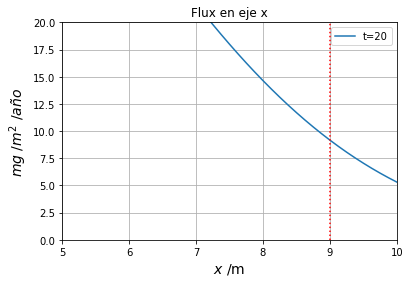

In [47]:

n_con=len(C_num)
plt.plot(x,flux_20,label="t=20")
plt.xlabel("$x$ /m ", size=14)
plt.ylabel("$mg $ /$m^2$ $/año $ ", size=14)
plt.grid()
plt.legend()
plt.axvline(x=9, color='red', linestyle='dotted')
plt.xlim(5,10)
plt.ylim(0,20)
plt.title("Flux en eje x")
# plt.xlim(0,1)
plt.show()

Ocupamos el último vector en t=20, se debe ubicar el punto en x=9:

In [ ]:
ind=round(200*9/25)
print(ind)

In [ ]:
c_20=C_num[-1]
flux_t20=(c_20[ind+1]-c_20[ind-1])/(2*dx)*(-D_h)+c_20[ind]*v
print(flux_t20)

#### P7) Encuentre año en que el flux de contaminante organico hacia el acuifero sea maximo (x=9)

In [ ]:
# Tiempo inicial
t_0=0

# Tiempo final
t_f = 30

# Grabe los resultados después de una fracción que estime conveniente. Por ejemplo, t = 3 s:
write_interval= 1

In [ ]:
## Algoritmo FTCS

# Lista en que se acumulan los tiempos donde se graban los perfiles de concentración
t_vec=[]

# Lista en que se acumulan los perfiles de concentración para cada write_interval
C_num=[]

# Inicializar vector que contiene la concentración inicial 
C_inicial=np.ones(len(A))*0


# Copie la temperatura T en otra variable, utilizando la función np.copy()
C_old=np.copy(C_inicial)


#Inicialización de tiempo inicial y final
t=t_0
t_max=t_f

# Iteración de evolución
while t<t_max:
    
    # Actualizar nodos interiores
    C_new=C_old+(np.dot(A,C_old)+b)*dt
        
    # Actualizar tiempo
    t+=dt
        
    # Actualizar condiciones de borde
    C_new[0]=c_0*np.exp(-beta*t)
    C_new[-1]=(4*C_new[-2]-C_new[-3])/3
    
        
        
    # Crear una copia de la nueva temperatura
    C_old=np.copy(C_new)


    # Definir un control de flujo para guardar el perfil de temperatura
    # cada vez que se cumpla un intervalo de tiempo previamente definido
    if (t%write_interval)<1.1*dt and t-dt>0:
        # Guardamos el perfil de temperatura
        C_num.append(C_new)
        
        # Guardamos el tiempo
        t_vec.append(t)
    


In [ ]:
fig, ax=plt.subplots(1,1,figsize=[5,4])
n_con=len(C_num)
cividis=cm.get_cmap("cividis",n_con)
colour=[cividis(i/n_con) for i in range(n_con)]

for i in range(len(C_num)):
    plt.plot(x,C_num[i],color=colour[i],label="t=%.0f y" % t_vec[i])

plt.xlabel("$x$ /m ", size=14)
plt.ylabel("$mg $ $/L $ ", size=14)
plt.grid()
plt.legend()
# plt.xlim(0,1)
plt.show()

In [ ]:
fluxmax=0
t_max=0
cont=0
for i in range(0,len(C_num)):
    C_i=C_num[i]
    flux=(-D_h*(C_i[ind+1]-C_i[ind-1])/(2*dx)+v*C_i[ind])*1000
    if flux>fluxmax:
        fluxmax=flux
        t_max=t_vec[i]
        
print(fluxmax,t_max)

El flux másico máximo es de 10.41 mg/($m^2$ $año$), que ocurre a los 25 años.